src: from the paper, [Simple and scalable predictive uncertainity using deep ensembles.](https://arxiv.org/abs/1612.01474)


In [305]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

In [306]:
# ensemble size
M = 5 

# On a toy dataset

need to reset random seed in each call, cant be in a different cell: https://stackoverflow.com/questions/21494489/what-does-numpy-random-seed0-do


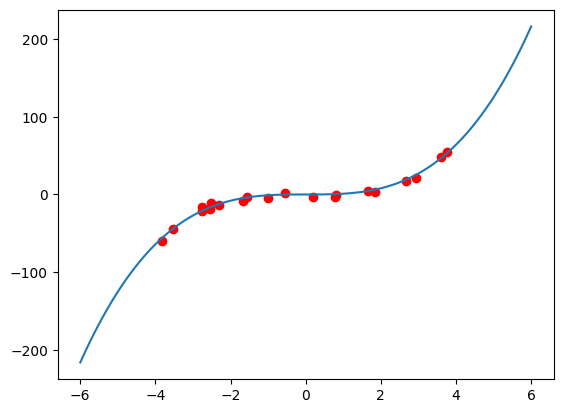

In [307]:
np.random.seed(42)
N=20

X_train = torch.tensor(np.random.uniform(-4,4,N)).float()
eps = torch.tensor(np.random.normal(0,3,N)).float()
y_train = X_train**3 + eps

X_test = torch.tensor(np.linspace(-6,6,100)).float()
y_test = X_test**3

plt.scatter(X_train, y_train,c='r')
plt.plot(X_test, y_test)
plt.show()

## Emperical variance, just training $M$ normal networks


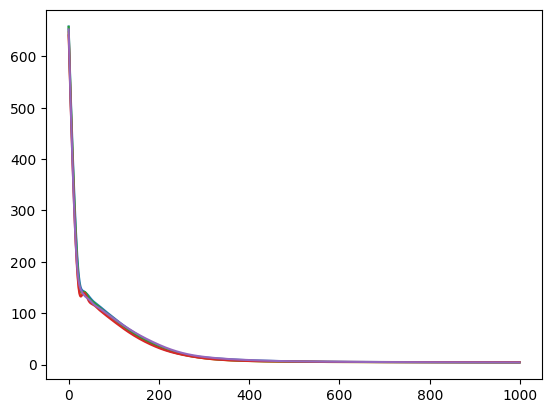

In [308]:
class MLP(nn.Module):
    def __init__(self, n_in, n_out):
        super().__init__()
        self.n_in=n_in
        self.n_out=n_out
        self.net = nn.Sequential(
            nn.Linear(n_in, 100),
            nn.ReLU(),
            nn.Linear(100,n_out)
        )
    def forward(self,x):
        return self.net(x)

def loss_fn(yhat,y):
    return F.mse_loss(yhat,y)



def train_model(model, loss_fn, epochs=1000, lr=1e-2):
    optimizer = torch.optim.Adam(model.parameters(),lr=lr)
    train_loss = []
    for _ in range(epochs):
        # zero gradients
        optimizer.zero_grad()
        # forward pass 
        rand_indices = torch.randperm(len(X_train))
        X_train_randorder = X_train[rand_indices]
        y_train_randorder = y_train[rand_indices]
        yhat = model(X_train_randorder.unsqueeze(-1)).flatten()
        loss = loss_fn(yhat,y_train_randorder)
        # backward pass
        loss.backward()
        optimizer.step()
        # metrics
        train_loss.append(loss.item())
    return model, train_loss

models = []
losses = []
# ensemble
for _ in range(M):
    model,loss= train_model(MLP(1,1),loss_fn)
    models.append(model)
    losses.append(loss)
for train_loss in losses:
    plt.plot(train_loss)

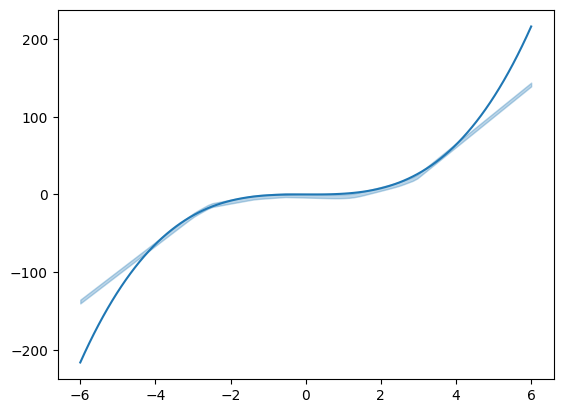

In [309]:
plt.plot(X_test,y_test)
outputs= []
for model in models:
    yhat_test= model(X_test.unsqueeze(-1)).flatten().detach()
    outputs.append(yhat_test)
outputs = torch.vstack(outputs) # (M,100)

mean_vector = torch.mean(outputs, dim=0)
squared_diff = (outputs - mean_vector)**2
# var =  E((X-E(X))^2)
variance = torch.mean(squared_diff)
std_dev = torch.sqrt(variance).item()

plt.fill_between(
    X_test,
    mean_vector - 3 * std_dev,
    mean_vector + 3 * std_dev,
    color="C0",
    alpha=0.3,
)

## Predicting mean and variance in the network

- Scoring function: For example, negative log likelihood is a scoring function
- Adverserial training: throw in some adverserial examples into the mix
- Ensemble : Combine means and variances from the different networks


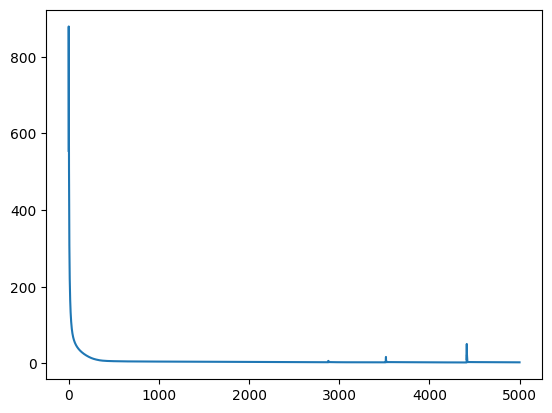

In [310]:
class ScoreMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 100),
            nn.ReLU(),
            nn.Linear(100,100),
            nn.ReLU(),
            # nn.Linear(100,100),
            # nn.ReLU(),
        )
        self.mean_fc = nn.Linear(100,1)
        self.var_fc = nn.Linear(100,1)
    def forward(self,x):
        out =  self.net(x)
        mean = self.mean_fc(out)
        var = self.var_fc(out)
        # softplus to ensure positive variance
        var = F.softplus(var)+1e-6
        return mean.flatten(), var.flatten()



def score_loss_fn(mean,var,y):
    return ((torch.log(var)/2) + ((y-mean)**2)/(2*var)).mean()



model = ScoreMLP()
epochs=5000
lr=1e-3
optimizer = torch.optim.Adam(model.parameters(),lr=lr)
train_loss = []
# grad wrt data calculated for adverserial example generation
# X_train_adv = X_train.clone()
X_train.requires_grad=True
eps_adv = 0.01*12 # 1% of data input (x) rage as suggested
for i in range(epochs):
    # zero gradients
    optimizer.zero_grad()
    # forward pass 
    mean,var = model(X_train.unsqueeze(-1))
    loss = score_loss_fn(mean,var,y_train)
    if i>0:
        # when i>0, the gradient wrt data exists, as it's been calcuated by loss.backward()
        # use that to generate an adverserial example, and add adverserial loss to
        # original loss to make the predictions more robust
        X_train_adv = X_train + eps_adv*X_train.grad.sign()
        # zero out the data gradients, so that they don't accumulate
        X_train.grad.data=torch.zeros_like(X_train)
        # generate output for adverserial example
        mean_adv,var_adv = model(X_train_adv.unsqueeze(-1))
        # add adverserial loss to normal loss
        loss += score_loss_fn(mean_adv, var_adv, y_train)

    # backward pass
    loss.backward()
    optimizer.step()
    # metrics
    train_loss.append(loss.item())
    # break
plt.plot(train_loss)

In [311]:
train_loss[-1]

2.760883331298828

torch.Size([100])


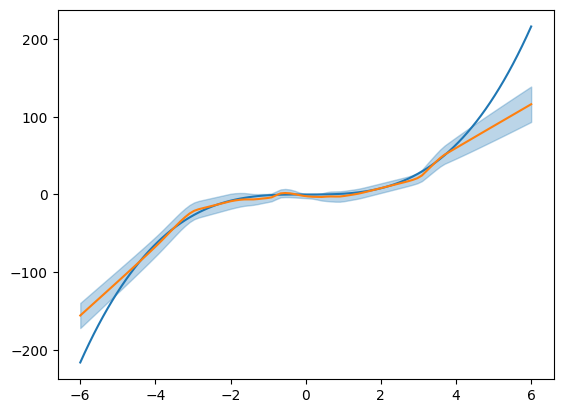

In [312]:
plt.plot(X_test,y_test)
mean,var = model(X_test.unsqueeze(-1))
print(mean.shape)
mean = mean.detach().numpy()
var = var.detach().numpy()
std_dev = var**0.5
plt.plot(X_test,mean)
plt.fill_between(
    X_test,
    mean - 3 * std_dev,
    mean + 3 * std_dev,
    color="C0",
    alpha=0.3,
)
# plt.scatter(X_train,y_train,c='r')

In [313]:
# ensemble
models = []
for _ in range(M):
    model = ScoreMLP()
    epochs=3000
    lr=1e-3
    optimizer = torch.optim.Adam(model.parameters(),lr=lr)
    train_loss = []
    # for adverserial training
    X_train.requires_grad=True
    eps_adv = 0.01*12
    for _ in range(epochs):
        # zero gradients
        optimizer.zero_grad()
        # forward pass 
        rand_indices = torch.randperm(len(X_train))
        # X_train_randorder = X_train[rand_indices]
        # y_train_randorder = y_train[rand_indices]
        mean,var = model(X_train.unsqueeze(-1))
        loss = score_loss_fn(mean,var,y_train)
        # adverserial training
        if i>0:
            X_train_adv = X_train + eps_adv*X_train.grad.sign()
            X_train.grad.data=torch.zeros_like(X_train)
            mean_adv,var_adv = model(X_train_adv.unsqueeze(-1))
            loss += score_loss_fn(mean_adv, var_adv, y_train)
        # backward pass
        loss.backward()
        optimizer.step()
        # metrics
        train_loss.append(loss.item())
    models.append(model)

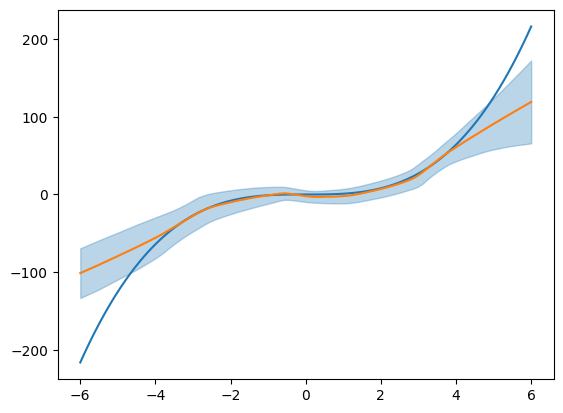

In [314]:
plt.plot(X_test,y_test)
means= []
vars=[]
for model in models:
    mean,var = model(X_test.unsqueeze(-1))
    mean=mean.detach()
    var = var.detach()
    means.append(mean)
    vars.append(var)

means = torch.vstack(means)
vars = torch.vstack(vars)

final_mean = torch.mean(means,dim=0)
final_var =  torch.mean(vars+(means**2), axis = 0) - final_mean**2
std_dev = final_var**0.5

plt.plot(X_test, final_mean)
plt.fill_between(
    X_test,
    final_mean - 3 * std_dev,
    final_mean + 3 * std_dev,
    color="C0",
    alpha=0.3,
)

# Testing with jagged inputs


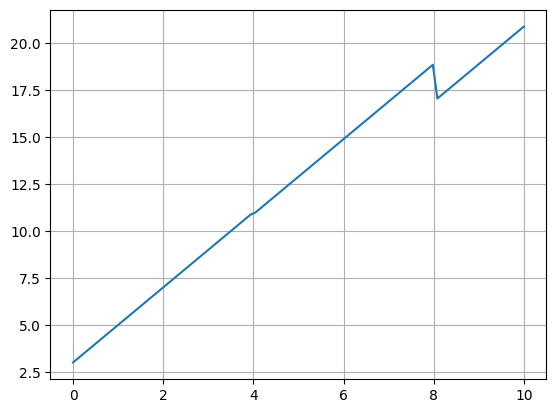

In [335]:
x= np.linspace(0,10,100)
y = 2*x+3

def heaviside(x,t,mag=1):
    out = np.zeros_like(x)
    out[x>=t]=mag
    return out

y-=heaviside(x,t=4,mag=0.1)
y-=heaviside(x,t=8,mag=2)
plt.plot(x,y)
plt.grid()
# plt.gca().set_aspect(1)